In [1]:
import cv2
import numpy as np
from tqdm import trange
from flygym import Simulation, Camera
from flygym.arena import FlatTerrain

In this example, we will simulate a fly chasing another fly based on vision. This is similar to the [visual taxis task in week 4](https://github.com/NeLy-EPFL/cobar-exercises/blob/main/week4/1_vision.ipynb), but the ball will be replaced by a walking fly.

For multi-fly simulation, we might want to control the flies differently and have different observation/action spaces for different flies. Therefore, we will inherit from `Fly` and implement different logic in the `pre_step` method. 

In [2]:
from hybrid_turning_fly import HybridTurningFly
from movodor_arena import MovOdorArena
from odor_turning_fly import OdorTaxisFly


In [3]:
# random state seed for reproducibility
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[0, 0, 10],[1, 1, 10]], dtype=np.float32)

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[0, 1],[1, 0]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

# Gains for the two odors (negative = attractive, positive = aversive)
odor_gains = np.array([-500, 80])

In [4]:
timestep = 1e-4 # 0.1 ms

# fly0 = HybridTurningFly(
#     name="0",
#     timestep=timestep,
#     enable_adhesion=True,
#     spawn_pos=(0, 0, 0),
# )

fly0 = OdorTaxisFly(
    name="0",
    odor_threshold = 0.5,
    odor_dimensions=odor_dimensions,
    odor_gains=odor_gains,
    timestep=timestep,
    enable_adhesion=True,
    enable_olfaction=True,
    spawn_pos=(0, 0, 0),
)


fly1 = HybridTurningFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 0, 0.5),
)


arena = MovOdorArena(
    size=(300, 300),
    friction=(1, 0.005, 0.0001),
    num_sensors=4,
    move_speed=0,
    move_direction="right",
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

#arena = FlatTerrain() # This is the default arena

# THIS IS THE CAMERA THAT WILL BE USED FOR FOLLOWING THE CENTER OF MASS OF THE FLY
mov_birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="mov_birdeye_cam",
    mode="fixed",
    pos=(15, 0, 40), # (15, 0, 40) the 40 is the camera height which is constant
    euler=(0, 0, 0),
    fovy=45,
)
#-------------------------------------------------------------------------------

cam = Camera(
    fly=fly0,
    camera_id="Animat/camera_left", # This is not used as argument
    play_speed=0.5,
    window_size=(800, 608),
)


sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

In [5]:
sim.reset(seed=0)
odor_source_hist = []
for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

run_time = 3 # in seconds
t = np.arange(0, run_time, timestep)

fly0_actions = (
    np.column_stack(
        [
            np.abs(np.cos(t * np.pi / 2)),
            np.abs(np.sin(t * np.pi / 2)),
        ]
    )
    * 1.2
)
fly1_actions = (
    np.column_stack(
        [
            np.abs(np.cos(t * np.pi / 2)),
            np.abs(np.sin(t * np.pi / 2)),
        ]
    )
    * 1.2
)

second_cam_frames = []
x = None
y = None
alpha = 1e-1

control_signal = np.zeros(odor_dimensions)
obs_history = []
for i in trange(len(t)):
    #print something every 1000 steps
    # if i % 1000 == 0:
    #     print(obs["0"]["fly"])

    obs, _, _, _, info = sim.step(
        {
            "0": control_signal,
            "1": fly1_actions[i],
        }
    )

    control_signal = fly0.process_odor_intensities(obs["0"]["odor_intensity"])
    
    #To bind the odor source position to a fly position
    for j in range(len(arena.odor_source)):
        arena.odor_source[j] = obs[str(j)]["fly"][0]
        arena.odor_source[j][2] = 4    #add an offset to the odor source position on z axis

    #THIS PART IS TO MAKE THE SECOND CAMERA FOLLOW THE CENTER OF MASS OF THE FLY ------------------------------------------------
    render_res = sim.render()[0]

    if render_res is not None:
        second_cam = sim.physics.bind(mov_birdeye_cam)

        x_new = obs["0"]["fly"][0][0]
        y_new = obs["0"]["fly"][0][1]

        if x is None:
            x = x_new
        
        if y is None:
            y = y_new

        x = (1 - alpha) * x + alpha * x_new
        y = (1 - alpha) * y + alpha * y_new

        second_cam.pos[0] = x
        second_cam.pos[1] = y

        second_img = sim.physics.render(
            width=700, height=560, camera_id="mov_birdeye_cam"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)
        #------------------------------------------------------------------------------------------------

    odor_source_hist.append(arena.odor_source.copy())
    obs_history.append(obs)

 14%|█▍        | 4250/30000 [02:45<15:51, 27.05it/s]

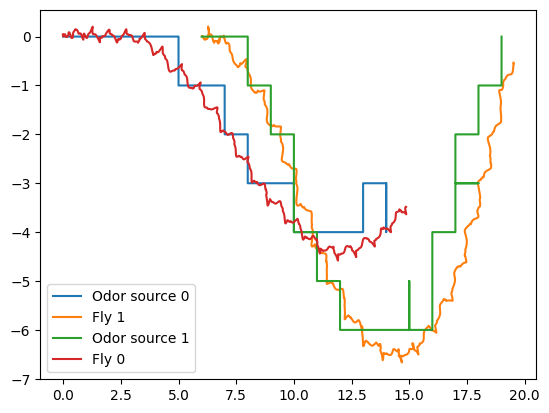

In [17]:
# plot the odor source trajectory vs fly trajectory
import matplotlib.pyplot as plt
fly_pos_hist_1 = np.array([obs["1"]["fly"][0, :2] for obs in obs_history])
fly_pos_hist_0 = np.array([obs["0"]["fly"][0, :2] for obs in obs_history])
odor_source_hist = np.array(odor_source_hist)
plt.plot(odor_source_hist[:,0,0], odor_source_hist[:,0,1], label="Odor source 0")
plt.plot(fly_pos_hist_1[:,0], fly_pos_hist_1[:,1], label="Fly 1")
plt.plot(odor_source_hist[:,1,0], odor_source_hist[:,1,1], label="Odor source 1")
plt.plot(fly_pos_hist_0[:,0], fly_pos_hist_0[:,1], label="Fly 0")
plt.legend()
plt.show()

In [22]:
#birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
cam.save_video("video_chasing/chasing_with_odor3.mp4")

In [23]:
from IPython.display import Video

Video("video_chasing/chasing_with_odor3.mp4", width=800, height=608)